# Check difference between TS generated by GSM and optimized TS using initial guess from NN

In [2]:
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem

import numpy as np
from scipy import stats
from scipy.optimize import least_squares
import pandas as pd
# LP: from gaussian import Gaussian

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
### get test r,p,ts geometries and model ts geometries
### then load d_init - how did he get d_init.npy?
### tests all len 842, model_ts_no_opt is 840

# base_folder = '/home/lagnajit/Dropbox (MIT)/Linux/PycharmProjects/dist2coords/log/v4/2layers_256hs_3its/'
base_folder = '../model_data/'
test_ts_file = base_folder + 'test_ts.sdf'
reactant_file = base_folder + 'test_reactants.sdf'
product_file = base_folder + 'test_products.sdf'
model_ts_no_opt_file = base_folder + 'model_ts.sdf'

test_ts = Chem.ForwardSDMolSupplier(test_ts_file, removeHs=False, sanitize=False)
test_ts = [ts for ts in test_ts]

test_r = Chem.ForwardSDMolSupplier(reactant_file, removeHs=False, sanitize=False)
test_r = [x for x in test_r]

test_p = Chem.ForwardSDMolSupplier(product_file, removeHs=False, sanitize=False)
test_p = [x for x  in test_p]

model_ts_no_opt = Chem.ForwardSDMolSupplier(model_ts_no_opt_file, removeHs=False, sanitize=False)
model_ts_no_opt = [x for x  in model_ts_no_opt]

D_init = np.load(base_folder + 'D_init.npy')

In [17]:
model_ts = []
test_ts_gauss = []
r_mols = []
p_mols = []

rmsd = []
rmsd_no_opt = []
energies = []
indices = []

# LP: last 4 didn't spawn...(838 instead of 842)
# AV: not sure what spawn means
for i in range(840):
    
    N_atoms = test_ts[i].GetNumAtoms()
    norm_factor = N_atoms*N_atoms - N_atoms
    
    # LP: model_logfile = 'job_scripts/optfreq/model_ts' + str(i) + '.log'
    # LP: test_logfile = 'job_scripts/qchem_to_gauss_ts/test_ts' + str(i) + '.log'
    model_logfile = '../model_data/model_ts' + str(i) + '.log' 
    test_logfile = '../model_data/test_ts' + str(i) + '.log' 

    # LP: g16_model = Gaussian(logfile=model_logfile)
    # LP: g16_test = Gaussian(logfile=test_logfile)

    if g16_model.converge and g16_test.converge:
        
        x_model = g16_model.getGeometry(atomType=False)
        x_test = g16_test.getGeometry(atomType=False) 
        mol_model = Chem.Mol(test_ts[i]) # AV: should this be model tss???
        mol_test = Chem.Mol(test_ts[i])
        
        for j in range(mol_model.GetNumAtoms()):
            mol_model.GetConformer().SetAtomPosition(j, Geometry.Point3D(x_model[j][0], x_model[j][1], x_model[j][2]))
            mol_test.GetConformer().SetAtomPosition(j, Geometry.Point3D(x_test[j][0], x_test[j][1], x_test[j][2]))
        
        model_ts.append(mol_model)
        test_ts_gauss.append(mol_test)
        rmsd.append(AllChem.GetBestRMS(mol_model, mol_test))
        rmsd_no_opt.append(AllChem.GetBestRMS(model_ts_no_opt[i], mol_test))
        
        # AV: would it be better to use one of the ml energy libs here?
        energies.append((g16_model.getEnergy(), g16_test.getEnergy()))
        indices.append(i)
        
        
# only compare values for tss that converged
energy_diff = [(energy[0]-energy[1]) for energy in energies]
test_ts = [test_ts[i] for i in indices]
test_r = [test_r[i] for i in indices]
test_p = [test_p[i] for i in indices]
model_ts_no_opt = [model_ts_no_opt[i] for i in indices]
D_init = [D_init[i] for i in indices]

0


NameError: name 'g16_model' is not defined

In [4]:
def yield_mol_from_sdf(sdf_file):
    mol = []
    with open(sdf_file) as f:
        for line in f:
            mol.append(line.rstrip())
            if "$$$$" in line:
                yield mol
                mol = []
#         else:
#             yield mol
# check if last two lines are needed

get_reactants = yield_mol_from_sdf(reactant_file)
get_products = yield_mol_from_sdf(product_file)

reactant_smiles = []
for mol in get_reactants:
    try:
        reactant_smiles.append(mol[0])
    except Exception as e:
        print(mol)

product_smiles = []
reaction_smiles= []
for i, mol in enumerate(get_products):
    product_smiles.append(mol[0])

In [5]:
# check triangle inequalities for model structures before optimization

from itertools import permutations

for mol in model_ts_no_opt:
    d = Chem.Get3DDistanceMatrix(mol)
    for p in permutations(range(6), 3):
        assert(d[p[0], p[1]] + d[p[0], p[2]] >= d[p[1], p[2]])

In [6]:
def distance_to_gram(D):
    """ Convert distance to gram matrix """
    
    N = d_init.shape[0]
    D = np.square(d_init)
    
    D_row = np.sum(D, 0, keepdims=True) / N
    D_col = np.sum(D, 1, keepdims=True) / N
    D_mean = np.sum(D, keepdims=True) / N**2
    
    B = -0.5 * (D - D_row - D_col + D_mean)
    
    return B

def low_rank_approx_power(A, k=3, num_steps=10):
    
    # Low rank approximation
    A_lr = A
    u_set = []

    for kx in range(k):

        # Initialize eigenvector
        u = np.expand_dims(np.random.normal(size=np.shape(B)[:-1]), -1)

        # Power iteration
        for j in range(num_steps):
            u_norm = np.sqrt(max(np.sum(u**2, axis=0), 1e-3))
            u = u / u_norm
            u = np.dot(A_lr, u)

        # Rescale by sqrt(eigenvalue)
        eig_sq = np.sum(np.square(u), axis=0, keepdims=True)
        u = u / np.power(eig_sq + 1E-2, 0.25)
        u_set.append(u)
        A_lr = A_lr - np.dot(u, u.T)

    X = np.concatenate(u_set, axis=1)
    return X

def distances(X):
    """ Compute Euclidean distances from X """
    Dsq = np.square(np.expand_dims(X, 0) - np.expand_dims(X, 1))
    D = np.sqrt(np.sum(Dsq, axis=2))
    return D

def nlst_residuals(X, *D):
    X = np.reshape(X, [-1,3])
    return np.square(D - distances(X)).ravel()

In [7]:
model_init_mols = []

for idx in range(len(test_ts)):
    model_init_mol = Chem.Mol(test_ts[idx])
    d_r = Chem.Get3DDistanceMatrix(test_r[idx])
    d_p = Chem.Get3DDistanceMatrix(test_p[idx])
    d_init = (d_r + d_p) / 2
    
    B = distance_to_gram(d_init)
    x_init = low_rank_approx_power(B)
    res = least_squares(nlst_residuals, x0=np.ravel(x_init), args=d_init)
    X = np.reshape(res.x, [-1,3])
    
    for j in range(model_init_mol.GetNumAtoms()):
        model_init_mol.GetConformer().SetAtomPosition(j, Geometry.Point3D(X[j][0], X[j][1], X[j][2]))
    
    model_init_mols.append(model_init_mol)

In [8]:
model_dist = []
test_dist = []
model_init = []
model_init_2 = []

raw_model_rmsd = []
lst_rmsd = []

core_test_dist = []  # ground truth
core_model_dist = []  # d
core_model_init = []  # d_init
core_approx = []  # linear approx

for idx in range(len(test_ts)):
    
    N = test_ts[idx].GetNumAtoms()
    core_mask = (Chem.GetAdjacencyMatrix(test_p[idx]) + Chem.GetAdjacencyMatrix(test_r[idx])) == 1
    
    core_model_dist.append(np.ravel(Chem.Get3DDistanceMatrix(model_ts_no_opt[idx])*core_mask))
    core_model_init.append(np.ravel(D_init[idx][0:N,0:N]*core_mask))
    core_test_dist.append(np.ravel(Chem.Get3DDistanceMatrix(test_ts[idx])*core_mask))
    core_approx.append(np.ravel( (Chem.Get3DDistanceMatrix(test_r[idx])+Chem.Get3DDistanceMatrix(test_p[idx]))/2 *core_mask))

core_test_dist_all = np.concatenate(core_test_dist).ravel()
core_model_dist_all = np.concatenate(core_model_dist).ravel()
core_model_init_all = np.concatenate(core_model_init).ravel()
core_approx_all = np.concatenate(core_approx).ravel()

core_test_dist_all = core_test_dist_all[core_test_dist_all != 0]
core_model_dist_all = core_model_dist_all[core_model_dist_all != 0]
core_model_init_all = core_model_init_all[core_model_init_all != 0]
core_approx_all = core_approx_all[core_approx_all != 0]

IndexError: list index out of range

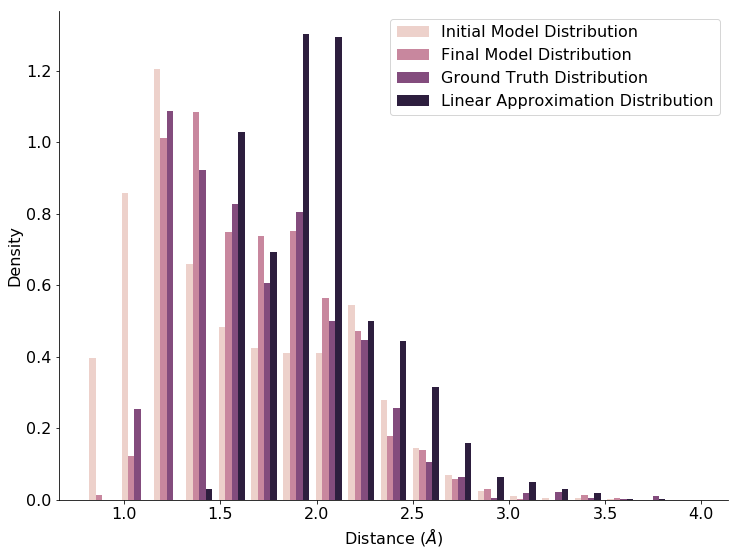

In [9]:
fig, ax = plt.subplots(figsize=(12,9))

bins = np.linspace(0.8, 4, 20)
ax.hist([core_model_init_all, core_model_dist_all, core_test_dist_all, core_approx_all], bins, range=(0.8, 4), density=True,\
        label=['Initial Model Distribution', 'Final Model Distribution', 'Ground Truth Distribution', 'Linear Approximation Distribution'],\
       color=sns.cubehelix_palette(4))
ax.legend(loc='upper right')

ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)   

#plt.savefig('/home/lagnajit/Desktop/ts_prediction_paper/dist_dists.pdf', bbox_inches='tight')

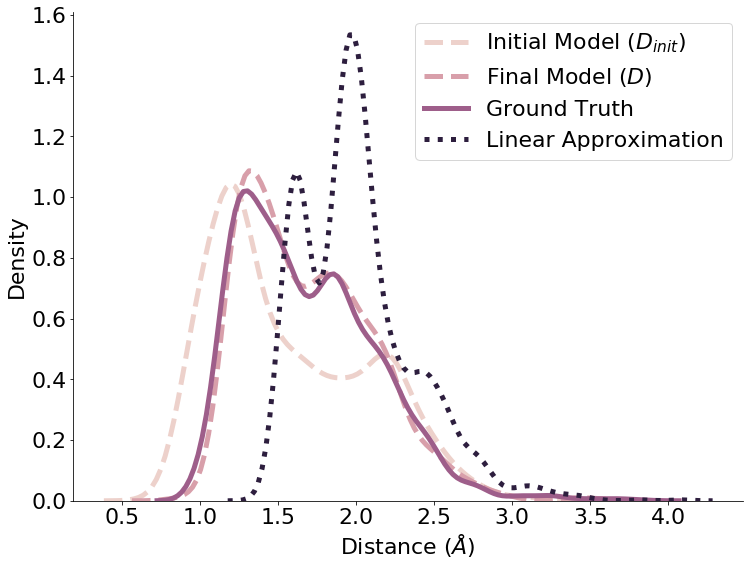

In [10]:
fig, ax = plt.subplots(figsize=(12,9))
sns.distplot(core_model_init_all, color=sns.cubehelix_palette(10)[0], kde_kws={"ls": '--', "shade": False, "lw": 5, "label": "Initial Model ($D_{init}$)"}, hist=False)# hist_kws={"alpha": 0.2})
sns.distplot(core_model_dist_all, color=sns.cubehelix_palette(10)[2], kde_kws={"ls": '--', "shade": False,"lw": 5, "label": "Final Model ($D$)"}, hist=False)#hist_kws={"alpha": 0.2})
sns.distplot(core_test_dist_all, color=sns.cubehelix_palette(10)[5], kde_kws={"ls": '-', "shade": False,"lw": 5, "label": "Ground Truth"}, hist=False)# hist_kws={"alpha": 0.2})
sns.distplot(core_approx_all, color=sns.cubehelix_palette(10)[-1], kde_kws={"ls": ':', "shade": False,"lw": 5, "label": "Linear Approximation"}, hist=False)#hist_kws={"alpha": 0.2})

ax.legend(loc='best')

ax.set_ylabel('Density', fontsize=22)
ax.set_xlabel(r'Distance ($\AA$)', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.legend(fontsize=22)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True) 

# plt.savefig('/home/lagnajit/Desktop/ts_prediction_paper/dist_dists.pdf', bbox_inches='tight')

In [ ]:
from rdkit.Chem.Draw import IPythonConsole 
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 
from IPython.display import Image, display
%matplotlib notebook

# good examples to show (7, 26, 27)

show_idx=622
display(test_ts[show_idx])
display(model_ts_no_opt[show_idx])
display(model_init_mols[show_idx])

In [ ]:
# save data
base_folder = '/home/lagnajit/Desktop/'
test_ts_file = base_folder + 'test_ts.sdf'
model_ts_no_opt_file = base_folder + 'ts_no_opt.sdf'
init_mols_file = base_folder + 'init.sdf'
r_file = base_folder + 'reactants.sdf'
p_file = base_folder + 'products.sdf'

test_ts_w = Chem.SDWriter(test_ts_file)
model_ts_no_opt_w = Chem.SDWriter(model_ts_no_opt_file)
init_w = Chem.SDWriter(init_mols_file)
r_w = Chem.SDWriter(r_file)
p_w = Chem.SDWriter(p_file)

for i in range(len(test_ts)):
    test_ts_w.write(test_ts[i])
    model_ts_no_opt_w.write(model_ts_no_opt[i])
    init_w.write(model_init_mols[i])
    r_w.write(test_r[i])
    p_w.write(test_p[i])

In [ ]:
base_folder = '/home/lagnajit/Dropbox (MIT)/Linux/PycharmProjects/dist2coords/log/v4/2layers_256hs_3its/'
test_losses = np.load(base_folder + 'test_loss.npy')
test_losses = [test_losses[i] for i in indices]

means, bin_edges, bin_number = stats.binned_statistic(raw_model_rmsd, test_losses, statistic='mean', bins=20)
stds, _, _ = stats.binned_statistic(raw_model_rmsd, test_losses, statistic=np.std, bins=20)
bin_centers = np.array([(bin_edges[i] + bin_edges[i-1]) / 2.0 for i in range(1, len(bin_edges))])

fig, ax = plt.subplots(figsize=(9,6))
ax.errorbar(bin_centers, means, yerr=stds)

In [ ]:
test_losses = np.load(base_folder + 'test_loss.npy')
successes_idx_df = [True if i in successes_idx else False for i in range(len(test_losses))]
indices_df = [indices.index(i) if i in indices else False for i in range(len(test_losses))]

# each list above corresponds to indices all test mols
# idx of 'indices' corresponds to pymol structure

In [ ]:
data = pd.DataFrame({'losses': test_losses, 'success': successes_idx_df, 'pymol': indices_df})
data.sort_values(by=['losses'], inplace=True, ascending=True)
data

In [ ]:
# negative examples
# pymol: 72, 623. 2, 155, 278, 242

# positive examples
# pymol: 300, 150, 68, 58, 168, 275, 

# false negative examples
# pymol: 65

# false positive examples
# pymol: 702, 20, 622

In [ ]:
test_r[32]

In [ ]:
test_p[32]

In [ ]:
successes_idx

In [9]:
model_init_no_opt = []

for idx in range(len(test_ts)):
    model_init_mol = Chem.Mol(test_ts[idx])
    d_r = Chem.Get3DDistanceMatrix(test_r[idx])
    d_p = Chem.Get3DDistanceMatrix(test_p[idx])
    d_init = (d_r + d_p) / 2
    
    B = distance_to_gram(d_init)
    x_init = low_rank_approx_power(B)
    
    for j in range(model_init_mol.GetNumAtoms()):
        model_init_mol.GetConformer().SetAtomPosition(j, Geometry.Point3D(x_init[j][0], x_init[j][1], x_init[j][2]))
    
    model_init_no_opt.append(model_init_mol)
    
init_no_opt_file = base_folder + 'init_no_opt.sdf'
init_no_opt_w = Chem.SDWriter(init_no_opt_file)
for i in range(len(test_ts)):
    init_no_opt_w.write(model_init_no_opt[i])

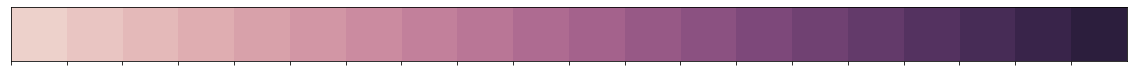

In [10]:
sns.palplot(sns.cubehelix_palette(20))

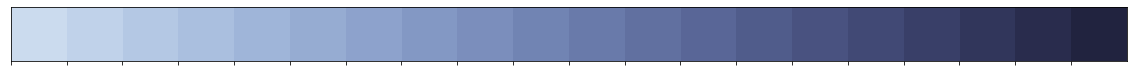

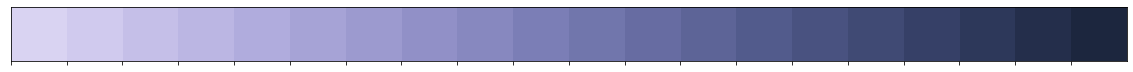

In [11]:
sns.palplot(sns.cubehelix_palette(20, rot=-.1))
sns.palplot(sns.cubehelix_palette(20, start=2.8, rot=.1))

In [12]:
# find unique reactants and products

all_intra_rs = Chem.ForwardSDMolSupplier('../../data/intra_rxns_reactants.sdf', removeHs=False, sanitize=False)
all_intra_rs = [x for x in all_intra_rs]

all_intra_ps = Chem.ForwardSDMolSupplier('../../data/intra_rxns_products.sdf', removeHs=False, sanitize=False)
all_intra_ps = [x for x in all_intra_ps]

unique_rs = []
for r in all_intra_rs:
    r_smi = Chem.MolToSmiles(r, allHsExplicit=True)
    unique_rs.append(r_smi)
print(len(set(unique_rs)))

unique_ps = []
for p in all_intra_ps:
    p_smi = Chem.MolToSmiles(p, allHsExplicit=True)
    unique_ps.append(p_smi)
print(len(set(unique_ps)))

# AV: 1086 unique reactants and 7606 unique products???

1086
7606


## find number of SCF cycles for TS jobs

In [25]:
from glob import glob
from gaussian import Gaussian
import numpy as np

n_success = 0
n_cycles = []
for _file in sorted(glob('job_scripts/optfreq/*.log')):
    job = Gaussian(logfile=_file)
    if job.converge:
        n_success += 1
        
        with open(_file) as f:
            n_cycle = 0
            for line in f:
                if 'Step number'in line:
                    n_cycle += 1
            n_cycles.append(n_cycle-1)

In [38]:
for _file in sorted(glob('job_scripts/optfreq/*.log')):
    job = Gaussian(logfile=_file)
    print(job.getGeometry().shape[0])

7
11
11
10
14
12
9
10
15
12
11
18
18
14
13
12
14
16
16
12
15
15
15
10
12
11
9
16
9
18
12
11
14
14
10
10
13
17
14
16
11
12
11
15
19
17
13
14
19
17
15
17
13
13
16
15
12
11
11
17
10
13
8
15
13
15
11
16
16
11
12
14
13
15
11
19
17
15
13
11
15
11
11
8
17
10
14
13
13
12
15
13
14
13
16
11
14
12
15
15
14
14
10
14
12
13
15
11
11
10
14
12
16
14
15
14
12
15
12
12
12
10
13
11
17
12
15
10
9
16
15
8
11
14
15
15
9
14
12
17
14
14
16
13
19
14
17
13
12
15
18
15
16
12
12
10
14
13
9
14
13
16
15
14
15
13
11
16
17
11
11
11
13
19
14
12
15
17
12
10
13
12
11
12
13
17
9
14
10
11
15
10
10
17
15
12
11
14
13
13
15
13
11
15
13
9
14
15
15
14
16
13
14
10
11
17
13
15
13
14
18
8
12
13
13
9
15
16
12
11
11
14
14
16
14
21
16
17
14
8
15
12
12
10
13
16
15
10
12
15
10
16
17
15
15
12
10
13
15
12
16
13
13
12
16
11
14
16
14
11
12
13
12
15
16
14
13
8
12
15
13
11
16
13
11
14
16
12
12
14
12
17
11
10
14
12
11
12
19
17
18
17
12
15
14
10
16
9
11
16
14
18
11
11
10
14
13
11
14
11
13
14
11
8
15
17
17
17
10
13
19
19
16
12
13
11
15
9
12
12

In [31]:
np.mean(n_cycles)

19.579651941097723

In [32]:
np.std(n_cycles)

13.045077377609694